# <div style="text-align: center">Исследование данных о прокате самокатов сервиса "GoFast".</div>

# Введение.
Исследуются данные о некоторых пользователях из нескольких городов, а также об их поездках.

**Условия использования приложения "GoFast":**
- без подписки
  - абонентская плата отсутствует;
  - стоимость одной минуты поездки — 8 рублей;
  - стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra
  - абонентская плата — 199 рублей в месяц;
  - стоимость одной минуты поездки — 6 рублей;
  - стоимость старта — бесплатно.


# Цели исследования и план работы.

- **Цели исследования:**
  - Анализ параметров поездок клиентов сервиса аренды самокатов "GoFast".<br>
  - Проверка следующих гипотез, которые могут помочь бизнесу вырасти:
    - Тратят ли пользователи с подпиской больше времени на поездки?
    - Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
    - Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?
    - Cнизилось ли значимо количество обращений в техподдержку, после обновления серверов, с которым взаимодействует приложение?
  - Оценка следующих параметров:
    - Оценка минимального количества промокодов, которые нужно разослать, чтобы вероятность непродления подписки 100 пользователями была ~5%.
    - Оценка вероятности того, что при рассылке 1 млн. пуш-уведомлений, их откроют не более 399,5 тыс. пользователей.<br><br>

- **План работы.**
  1. Загрузка данных.
  2. Предобработка данных.
  3. Исследовательский анализ данных.
  4. Объединение данных.
  5. Подсчёт выручки.
  6. Проверка гипотез.
  7. Распределения.

# Установка и загрузка библиотек, необходимых для работы.

In [1]:
# pandas для работы с датафреймами
import pandas as pd
# matplotlib и seaborn для построения графиков
import matplotlib.pyplot as plt
import seaborn as sns
# math.sqrt, math.isclose и numpy для вычислений
from math import sqrt, isclose
import numpy as np
# scipy.stats и scipy.stats.norm для проведения тестов
from scipy import stats as st
from scipy.stats import norm
# cufflinks для интерактивной визуализации некоторых графиков
!pip install cufflinks
import cufflinks as cf

## Загрузка данных.

In [2]:
# Загрузка датасетов
try:
    users = pd.read_csv('/datasets/users_go.csv')
    rides = pd.read_csv('/datasets/rides_go.csv')
    subs = pd.read_csv('datasets/subscriptions_go.csv')
except:
    users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
    rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
    subs = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

### Установка параметров визуального отображения элементов.

In [4]:
# Установим отображение всех столбцов при выводе датафрейма
pd.set_option('display.max_columns', None)

# Установим размер шрифта описания графиков
plt.rcParams['font.size'] = '12'

# Установим стиль отображения заголовков таблиц
styles = [dict(selector='caption',
              props=[('text-align', 'center'),
                     ('font-size', '120%'),
                     ('color', 'black'),
                     ('font-weight', 'bold')])]

# Установим тему оформления некоторых графиков
cf.set_config_file(theme='white', offline=True)

### Ознакомление с датафреймами.
Выведем основную информацию по датафреймам и их первые строки.

In [5]:
users.title = 'Пользователи'
rides.title = 'Поездки'
subs.title = 'Условия подписки'

for table in [users, rides, subs]:
    display(
        table.head(20)
        .style
        .set_caption(f'Датафрейм "{table.title}".')
        .set_table_styles(styles)
           )
    display(table.info())
    display(table.describe())
    display(table.columns)
    print('~' * 60)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None

user_id          age
count  1565.000000  1565.000000
mean    762.633866    24.922045
std     443.260155     4.553496
min       1.000000    12.000000
25%     378.000000    22.000000
50%     762.000000    25.000000
75%    1146.000000    28.000000
max    1534.000000    43.000000

Index(['user_id', 'name', 'age', 'city', 'subscription_type'], dtype='object')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


None

user_id      distance      duration
count  18068.000000  18068.000000  18068.000000
mean     842.869936   3070.659976     17.805011
std      434.734317   1116.831209      6.091051
min        1.000000      0.855683      0.500000
25%      487.000000   2543.226360     13.597563
50%      889.000000   3133.609994     17.678395
75%     1213.250000   3776.222735     21.724800
max     1534.000000   7211.007745     40.823963

Index(['user_id', 'distance', 'duration', 'date'], dtype='object')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


None

minute_price  start_ride_price  subscription_fee
count      2.000000          2.000000          2.000000
mean       7.000000         25.000000         99.500000
std        1.414214         35.355339        140.714249
min        6.000000          0.000000          0.000000
25%        6.500000         12.500000         49.750000
50%        7.000000         25.000000         99.500000
75%        7.500000         37.500000        149.250000
max        8.000000         50.000000        199.000000

Index(['subscription_type', 'minute_price', 'start_ride_price',
       'subscription_fee'],
      dtype='object')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


### Гистограммы количественных значений.

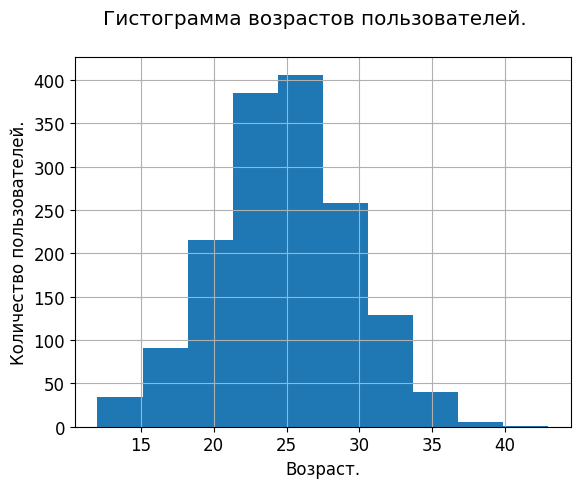

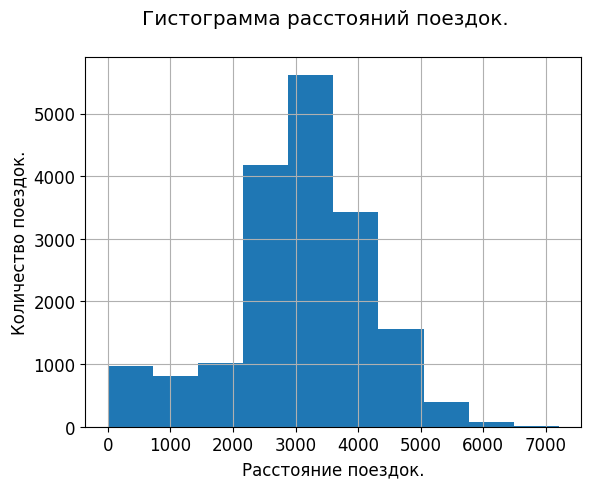

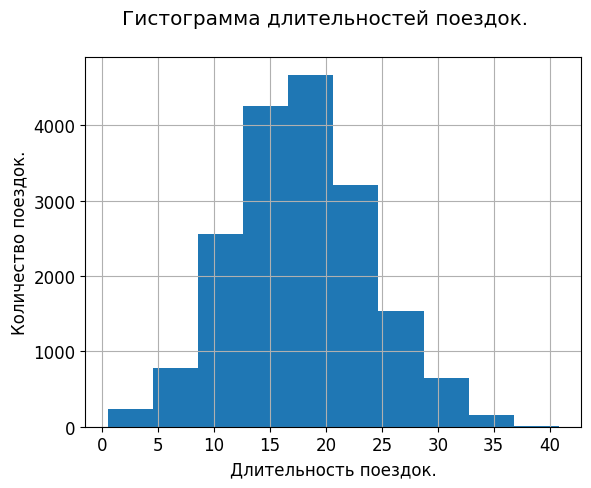

In [6]:
users['age'].hist()
plt.suptitle('Гистограмма возрастов пользователей.')
plt.xlabel('Возраст.')
plt.ylabel('Количество пользователей.')
plt.show();
rides['distance'].hist()
plt.suptitle('Гистограмма расстояний поездок.')
plt.xlabel('Расстояние поездок.')
plt.ylabel('Количество поездок.')
plt.show();
rides['duration'].hist()
plt.suptitle('Гистограмма длительностей поездок.')
plt.xlabel('Длительность поездок.')
plt.ylabel('Количество поездок.')
plt.show();

#### Выводы:
Предварительно по гистограммам количественных значений можно сказать следующее:
-  распределение возрастов пользователей стремится к нормальному, с немного утяжеленным правым хвостом;
- распределение расстояний поездок приближено к нормальному с немного утяжеленным правым хвостом и относительно высокими количествами поездок до 2000, на что необходимо обратить внимание при анализе;
- распределение длительности поездок пользователей стремится к нормальному, с немного утяжеленным правым хвостом.

### Проверка данных на явные дубликаты:

In [7]:
print(f'Дубликатов в датафрейме "Пользователи": {users.duplicated().sum()}.')
print(f'Дубликатов в датафрейме "Поездки": {rides.duplicated().sum()}.')

Дубликатов в датафрейме "Пользователи": 31.
Дубликатов в датафрейме "Поездки": 0.


Удалим явные дубликаты в датафрейме "Пользователи", т.к. они не несут никакой дополнительной информации, и проверим результат.

In [8]:
users = users.drop_duplicates()
print(f'Дубликатов в датафрейме "Пользователи" после удаления: {users.duplicated().sum()}.')

Дубликатов в датафрейме "Пользователи" после удаления: 0.


### Предварительная проверка на неявные дубликаты:

In [9]:
print('Неявных дубликатов в датафрейме "Пользователи":')
users[['user_id', 'name']].apply(lambda x: x.duplicated().sum())

Неявных дубликатов в датафрейме "Пользователи":


user_id       0
name       1340
dtype: int64

#### Выводы:
- Столбец `used_id` датафрейма "Пользователи" не содержит дубликатов, что означает уникальность идентификаторов пользователей.
- Столбец `name` содержит дубликаты, что обусловлено повторением имен. Т.к. различное написание имен в данном случае не критично, дополнительные действия не требуются.

### Предварительные выводы по составу датафреймов.
- Общая информация о датафреймах:
  - Датафрейм "Пользователи" - `users` содержит данные о 1565-ти пользователях, описанных четырьмя категориальными и одним количественным признаком.
  - Датафрейм "Поездки" - `rides` сожержит данные о 18068-ми поездках, описанных двумя количественными и одним временным признаком.
  - Датафрейм "Условия подписки" - `subs` содержит 2 записи с описанием условий, представленных одним категориальным и тремя количественными признаками.<br><br>

- Пропуски, дубликаты и аномалии в датафреймах:
  - Пропуски в датафреймах обнаружены не были.
  - Явные дубликаты в датафрейме "Пользователи" были обнаружены и удалены.
  - В столбцах `duration` и `distance` датафрейма `rides` присутствуют аномальные минимальные значения, - `0.5` и `0.86` соответственно, которые необходимо проверить.

## Предобработка данных.

### Проверка на пропуски и дубликаты.
- Отсутствие пропусков и  нулевых значений подтверждено в разделе [1.2](#Ознакомление-с-датафреймами.).
- Явные дубликаты были обработаны в разделе [1.3](#Проверка-данных-на-явные-дубликаты:).
- Наличие неявных дубликатов обусловлено несколькими поездками одних и тех же пользователей (e.g.: повторяющиеся имена).

### Проверка на аномальные значения.
Проверим минимальные значения столбцов `duration` и `distance` датафрейма `rides`.

#### Выведем записим с аномальными значениями длительности поездок.

In [10]:
(rides.merge(users, on='user_id', how='left')
 .query('duration < 2')
 .style
 .set_caption('Поездки длительностью менее 2 минут.')
 .set_table_styles(styles)
)

Такие записи необходимо удалить, т.к.
- точно определить причину появления аномальных значений невозможно;
- если оставить записи без изменений данные могут исказить результаты анализа;
- если заменить аномальные значения средними для дистанции поездки и если данные искажены по причине выдачи промокодов рассчитывать выручку по неоплаченным поездкам - некорректно.<br>

Удалим эти записи  и проверим результат.

In [11]:
rides_count = rides.shape[0]
rides = rides.drop(rides[rides['duration'] < 1].index)
print("Количество удаленных записей - ",
      f"{rides_count - rides.shape[0]}")
print("Количество аномальных записей после удаления - ",
      f"{rides.query('duration < 1').shape[0]}")

Количество удаленных записей -  95
Количество аномальных записей после удаления -  0


#### Выведем записим с аномальными значениями дистанций поездок.

In [12]:
(rides.query('distance < 10')
 .style
 .set_caption('Поездки с расстоянием менее 10 м.')
 .set_table_styles(styles)
)

#### Выводы:
- Из датафрейма "Поездки" - `rides` были удалены 95 записей с поездками с длительностью 30 секунд.<br>
Причинами появления таких значений могут быть ошибки получения / передачи данных, или, например, поскольку тарифицируется время, техническая невозможность записать полное время поездки при выдаче промокода на какую-то бесплатную длительность поездки (e.g.: промокод на час).<br>
- Минимальные значения дистанций соответствуют длительностям сессии и, скорее всего, обусловлены ознакомительными сессиями.

### Изменение типа столбца `date`.
- Измененим тип столбца `date` датафрейма `rides` на `datetime` и проверим результат.<span id="fn4">
- Округлим расстояние и длительность поездок до двух знаков после запятой для удобства расчетов и наглядности.<br>
Проверим результат.

In [13]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
print(f"Формат столбца 'date' после изменения типа: {rides['date'].dtype}.")

# Округлим значения
rides['distance'] = round(rides['distance'], 2)
rides['duration'] = round(rides['duration'], 2)

# Проверим результат
(rides
 .head(5)
 .style
 .set_caption('Датафрейм "Поездки".')
 .set_table_styles(styles))

Формат столбца 'date' после изменения типа: datetime64[ns].


### Создание столбца с номером месяца.
<span id="fn5">Перед созданием столбца с номером месяца, проверим какие годы присутствуют в данных.

In [14]:
print("Годы, присутствующие в данных:",
      f"{rides['date'].dt.year.unique()}")

Годы, присутствующие в данных: [2021]


Так как год в данных только один и ошибок при создании столбца с месяцем не возникнет, создадим столбец с номером месяца в датафрейме `rides` на основе столбца `date` и проверим результат.

In [15]:
rides['month'] = rides['date'].dt.month

(rides
 .head(5)
 .style
 .set_caption(f'Датафрейм "Поездки".')
 .set_table_styles(styles)
)

### Предобработка данных. Выводы:
- Из датафрейма "Поездки" - `rides` были удалены 95 записей с поездками с длительностью 30 секунд.
- Был изменен тип столбца `date` датафрейма `rides` на `datetime`;
- Был создан столбец с номером месяца в датафрейме `rides` на основе столбца `date`.

## Исследовательский анализ данных.
Описание и визуализация общей информации о пользователях и поездках.<span id="fn6">

### Частота встречаемости городов.
<span id="fn6">

In [16]:
# Выведем график
fig = (
    users['city'].value_counts()
    .iplot(kind='bar',xTitle='Города.',
           yTitle='Количество пользователей.',
           title='Количество пользователей по городам.',
           color=['royalblue'],
           asFigure=True))
fig.update_layout(title_x=0.45)
fig.show();

# --- > Версия 2. Дополнительный код.
(
    pd.DataFrame({'Кол-во пользователей:' : users['city'].value_counts()})
    .transpose()
    .style
    .set_caption('Частотность встречаемости городов.')
    .set_table_styles(styles)
)

#### Выводы:
- В Пятигорске и Москве больше всего и меньше всего клиентов соотетственно.

### Cоотношение пользователей с подпиской и без подписки.
<span id="fn7">

In [17]:
# Введем временную переменную для сводной таблицы с количеством
# пользователей с подписками разног типа
subs_ratio = pd.DataFrame()
subs_ratio['Без подписки.'] = (
    users.loc[users['subscription_type'] == "free", 'city'].value_counts())
subs_ratio['С подпиской "ultra"'] = (
    users.loc[users['subscription_type'] == "ultra", 'city'].value_counts())

# Выведем круговую диаграмму
fig = (
    subs_ratio[['Без подписки.', 'С подпиской "ultra"']]
    .sum()
    .reset_index()
    .rename(columns={'index' : 'index', 0 : 'sum'})
    .iplot(kind='pie',
           labels='index',
           values='sum',
           title='Распределение пользователей с подписками разного типа.',
           color=['brick', 'royalblue'],
           asFigure=True)
)
fig.update_layout(title_x=0.45)
fig.show();

# Выведем график
fig = (
    subs_ratio[['Без подписки.', 'С подпиской "ultra"']]
    .iplot(kind='bar',
           barmode='stack',
           xTitle='Города.',
           yTitle='Количество пользователей.',
           title='Количество пользователей разного типа по городам.',
           color=['brick', 'royalblue'],
           asFigure=True))
fig.update_layout(title_x=0.45)
fig.show();

# Выведем таблицу
display(pd.DataFrame(
    data={'С подпиской "Ultra":' :
          users.query('subscription_type == "ultra"')['city'].shape[0],
          'Без подписки:' :
          users.query('subscription_type == "free"')['city'].shape[0],
          'Кол-во подписчиков / кол-во без подписки:' :
          "{:.0%}".format(users.query('subscription_type == "ultra"')['city'].shape[0] /
                          users.query('subscription_type == "free"')['city'].shape[0]),
          'С подпиской от общего кол-ва:' :
          "{:.0%}".format(users.query('subscription_type == "ultra"')['city'].shape[0] /
                          users['city'].shape[0]),
          'Без подписки от общего кол-ва:' :
          "{:.0%}".format(users.query('subscription_type == "free"')['city'].shape[0] /
                          users['city'].shape[0])},
    index=['Пользователей'])
        .style.set_caption('Количество пользователей разного типа.')
        .set_table_styles(styles))

#### Выводы:
- Пользователи с подпиской составляют 46% от общего количества и их меньше, чем пользователей без подписки (56%).
- Самое большое число подписчиков и пользователей в общем в Пятигорске, Екатеринбурге и Ростове-на-Дону. Самое маленькое количество подписчиков и пользователей в Москве.
- Самое большое число пользователей без подписки в Пятигорске, Краснодаре и Екатеринбурге.

### Возраст пользователей.
<span id="fn8">Построим интерактивную диаграмму размаха, гистограммы и выведем таблицу с основными статистиками для возрастов пользователей.

In [18]:
# Создадим временные столбцы для анализа
users['Без подписки.'] = users.loc[users['subscription_type'] == "free", 'age']
users['С подпиской "ultra"'] = users.loc[users['subscription_type'] == "ultra", 'age']

# Построим общий график распределения
fig = (
    users['age']
    .iplot(kind='histogram',
           xTitle='Возраст.',
           yTitle='Количество пользователей.',
           title='Возраст пользователей.',
           colors=['royalblue'],
           asFigure=True))
fig.update_layout(title_x=0.45)
fig.show();

# Построим диаграмму размаха по категориям
fig = (
    users[['Без подписки.', 'С подпиской "ultra"']]
    .iplot(kind='box',
           boxpoints='outliers',
           yTitle='Возраст.',
           title='Распределение возрастов пользователей.',
           colors=['brick', 'royalblue'],
           asFigure=True))
fig.update_layout(title_x=0.45)
fig.show();

# Построим график распределения по категориям
fig = (
    users[['Без подписки.', 'С подпиской "ultra"']]
    .iplot(kind='histogram',
           xTitle='Возраст.',
           yTitle='Количество пользователей.',
           title='Возраст пользователей по категории.',
           colors=['brick', 'royalblue'],
           asFigure=True))
fig.update_layout(title_x=0.45)
fig.show();

# Удалим временные столбцы
users = users.drop(columns=['Без подписки.', 'С подпиской "ultra"'])

# Выведем таблицу со статистиками
(
    pd.DataFrame(users['age'].describe())
    .transpose()
    .style
    .set_caption('Основные статистики по возрасту пользователей.')
    .set_table_styles(styles)
)

#### Выводы:
- Распределения возраста близки к нормальному.
- Медианный возраст пользователя - 25 лет.
- Планы с подпиской более интересны пользователям от 18 до 33 лет.

### Расстояние, которое пользователь преодолел за одну поездку.
<span id="fn9">Построим диаграмму размаха, гистограмму и выведем таблицу с основными статистиками для преодоленных расстояний.

In [19]:
# Построим диаграмму размаха
fig = rides['distance'].iplot(kind='box',
                                boxpoints='outliers',
                                yTitle='Расстояние.',
                                title='Распределение преодоленных расстояний.',
                                colors=['royalblue'],
                                asFigure=True)
fig.update_layout(title_x=0.45)
fig.show();

# Построим гистограмму
fig = rides['distance'].iplot(kind='histogram',
                               xTitle='Расстояние.',
                               yTitle='Количество поездок.',
                               title='Распределение расстояний поездок.',
                               colors=['royalblue'],
                               asFigure=True)
fig.update_layout(title_x=0.45)
fig.show();

# Выведем таблицу со статистиками
(
    pd.DataFrame(rides['distance'].describe())
    .transpose()
    .style
    .set_caption('Основные статистики по преодоленным дистанциям.')
    .set_table_styles(styles)
)

#### Выводы:
- Медианное расстояние поездки - 3129м.
- Распределение расстояния поездок приближено к нормальному, за исключением выделяющегося отдельного распределения коротких поездок с расстояниями до ~1400м.

### Продолжительность поездок.
<span id="fn10">Построим диаграмму размаха, гистограмму и выведем таблицу с основными статистиками для продолжительности поездок.

In [20]:
# Построим диаграмму размаха
fig = rides['duration'].iplot(kind='box',
                                boxpoints='outliers',
                                yTitle='Продолжительность поездки.',
                                title='Распределение продолжительности поездок.',
                                colors=['royalblue'],
                                asFigure=True)
fig.update_layout(title_x=0.45)
fig.show();

# Построим график распределения
fig = rides['duration'].iplot(kind='histogram',
                               xTitle='Продолжительность поездки.',
                               yTitle='Количество поездок.',
                               title='Распределение продолжительности поездок.',
                               colors=['royalblue'],
                               asFigure=True)
fig.update_layout(title_x=0.45)
fig.show();

# Выведем таблицу со статистиками
(
    pd.DataFrame(rides['duration'].describe())
    .transpose()
    .style
    .set_caption('Основные статистики по продолжительности поездок.')
    .set_table_styles(styles)
)

#### Выводы:
- Продолжительности поездок распределены нормально.
- Медианная продолжительность поездки - 17 минут.
- Поездки продолжительностью более 35 минут - редки.

### Исследовательский анализ данных. Выводы:
- Пользователи с подпиской составляют 46% от общего количества.
- Самое большое число подписчиков и пользователей в общем в Пятигорске, Екатеринбурге и Ростове-на-Дону.
- Медианный возраст пользователей - 25 лет. Подписка более интересны пользователям от 18 до 33 лет.
- Средняя поездка:
  - продолжительность - 17 минут;
  - расстояние - 3129м.

## Объединение данных

### Объединение данных о пользователях, поездках и подписках в один датафрейм.
<span id="fn11">

In [21]:
# Объединим датафреймы и проверим результат
data = rides
data = data.merge(users, on='user_id', how='left')
data = data.merge(subs, on='subscription_type', how='left')

# Вывод объединенного датафрейма
display(data
        .head(10)
        .style
        .set_caption('Объединенный  датафрейм.')
        .set_table_styles(styles)
       )


# Проверка размерности созданного датафрейма
print("~" * 60)
if data.shape[0] == rides.shape[0]:
    print("\n\033[1m", "Количество записей в сводном датафрейме",
          "соответствует количеству записей в исходном.", "\033[0m")
else:
    print("\n\033[1m", "Количество записей в сводном датафрейме",
          "не соответствует количеству записей в исходном.", "\033[0m")

# Проверка пропусков в созданном датафрейме
print("~" * 60)
print("\n\033[1m", "Количество пропусков в объединенном датафрейме по столбцам:\n", "\033[0m")
display(data.isna().sum())

# вывод общей информации о созданном датафрейме
print("~" * 60)
print("\n\033[1m", "Информация об объединенном датафрейме:\n", "\033[0m")
display(data.info())

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

 Количество записей в сводном датафрейме соответствует количеству записей в исходном. 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

 Количество пропусков в объединенном датафрейме по столбцам:
 


user_id              0
distance             0
duration             0
date                 0
month                0
name                 0
age                  0
city                 0
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

 Информация об объединенном датафрейме:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17973 entries, 0 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   distance           17973 non-null  float64       
 2   duration           17973 non-null  float64       
 3   date               17973 non-null  datetime64[ns]
 4   month              17973 non-null  int32         
 5   name               17973 non-null  object        
 6   age                17973 non-null  int64         
 7   city               17973 non-null  object        
 8   subscription_type  17973 non-null  object        
 9   minute_price       17973 non-null  int64         
 10  start_ride_price   17973 non-null  int64         
 11  subscription_fee   17973 non-null  int64         
dtypes: datetime6

None

#### Выводы:
- Количество записей в сводном датафрейме соответствует количеству записей в исходном.
- Пропуски в сводном датафрейме отсутствуют.<br>

Объединение датафреймов `rides`, `users` и `subs` было проведено успешно.

### Создание двух датафреймов из датафрейма, созданного на этапе 4.1:
- c данными о пользователях без подписки;
- с данными о пользователях с подпиской.

In [22]:
# Создадим датафреймы и проверим результат
data_nosub = data[data['subscription_type'] == 'free']
data_sub = data[data['subscription_type'] == 'ultra']
display(data_nosub
        .head(10)
        .style
        .set_caption('Датафрейм: Пользователи без подписки.')
        .set_table_styles(styles))
(data_sub
 .head(10)
 .style
 .set_caption('Датафрейм: Пользователи с подпиской.')
 .set_table_styles(styles))

### Визуализация информации о расстоянии и времени поездок для пользователей обеих категорий.
<span id="fn12">

In [23]:
# Построим графики дла расстояний
distance_pivot = pd.DataFrame()
distance_pivot['Без подписки.'] = data_nosub['distance']
distance_pivot = distance_pivot.reset_index(drop=True)
distance_pivot['С подпиской.'] =  data_sub['distance']
fig4 = distance_pivot[['Без подписки.', 'С подпиской.']].iplot(kind='histogram',
                                            xTitle='Расстояние.',
                                            yTitle='Количество поездок.',
                                            title='Распределение расстояний поездок.',
                                            colors=['brick', 'royalblue'],
                                            asFigure=True)
fig4.update_layout(title_x=0.45)
fig4.show();

# Построим графики дла времени
duration_pivot = pd.DataFrame()
duration_pivot['Без подписки.'] = data_nosub['duration']
duration_pivot = duration_pivot.reset_index(drop=True)
duration_pivot['С подпиской.'] =  data_sub['duration']
fig5 = (
    duration_pivot[['Без подписки.', 'С подпиской.']]
    .iplot(kind='histogram',
           xTitle='Длительность поездок.',
           yTitle='Количество поездок.',
           title='Распределение длительности поездок.',
           textinfo=f"Без подписки. Среднее - {round(duration_pivot['Без подписки.'].median(), 0)}" + "С подпиской.",
           colors=['brick', 'royalblue'],
           asFigure=True)
        )
fig5.update_layout(title_x=0.45)
fig5.show();

#---> Дополнительный код. Версия 2.
# Выведем таблицу со статистиками
tuples = ([('Без подписки.', 'Расстояние:'),
           ('Без подписки.', 'Длительность:'),
           ('С подпиской.', 'Расстояние:'),
           ('С подпиской.', 'Длительность:')])

display(
    pd.DataFrame([data_nosub['distance'].describe(),
                  data_nosub['duration'].describe(),
                  data_sub['distance'].describe(),
                  data_sub['duration'].describe()],
                  index=pd.MultiIndex.from_tuples(tuples))
    .style
    .set_caption('Основные статистики для пользователей обеих категорий.')
    .set_table_styles(styles))

#### Выводы:
- Рисунки распределения дублируются с учетом того, что пользователи без подписки чаще берут самокаты в аренду. На графике расстояний виден рост до 1500 м. - короткие поездки, и в районе 3000 м. - длительные.
- Пользователи без подписки:
  - чаще проезжат большие и малые расстояния;
  - чаще пользуются самокатами короткое время;
  - чаще берут самокаты в аренду;
  - среднее расстояние поездки - ~3000 м.;
  - среднее время поездки - ~17 минут;
- Пользователи с подпиской:
  - среднее расстояние поездки - ~3100 м.;
  - средняя длительность поездки - ~18 минут;
  - часто проезжают около 3000 м.;
  - особенно выделяются значения 1000 м., 3150 м. и 4000 м.

## Подсчёт выручки

### Создание датафрейма с агрегированными данными о поездках.

In [24]:
# Создадим датафрейм и проверим результат
data_user_info = data.pivot_table(index=['user_id', 'month'],
                                  values=['distance', 'duration'],
                                  aggfunc=({'distance' : sum,
                                            'duration' : [sum, len]}))
data_user_info.columns = data_user_info.columns.to_flat_index()
data_user_info.columns = ['distance', 'count', 'duration']
(data_user_info
 .head(10)
 .style
 .set_caption('Агрегированные данные о поездках.')
 .set_table_styles(styles))

### Добавление столбца с помесячной выручкой.

In [25]:
# Проверка наличия всего одного типа подписки для каждого клиента
i = 0
for a in data.groupby('user_id')['subscription_type'].unique():
    while len(a) > 1:
        i += 1

if i > 0:
    print('Присутствуют клиенты с несколькими видами подписок.')
else:
    print('У каждого клиента всего один тип подписки.')


# Подсчёт выручки
data_user_info[['minute_price',
                'start_ride_price',
                'subscription_fee',
                'subscription_type']] = (
    data.groupby(['user_id', 'month'])[['minute_price',
                                        'start_ride_price',
                                        'subscription_fee',
                                        'subscription_type']].first())

data_user_info['revenue'] = (
    data_user_info['start_ride_price'] *
    data_user_info['count'] +
    data_user_info['minute_price'] *
    np.ceil(data_user_info['duration']) + #---> Изменение в коде. Версия 2.
    data_user_info['subscription_fee']
).astype('int')

data_user_info = data_user_info.drop(columns=['minute_price',
                                               'start_ride_price',
                                               'subscription_fee'])

# Проверка результата
(data_user_info
 .head(10)
 .style
 .set_caption('Агрегированные данные о поездках.')
 .set_table_styles(styles))

У каждого клиента всего один тип подписки.


## Проверка гипотез.

### Проверка гипотезы о времени.
Тратят ли пользователи с подпиской больше времени на поездки?<br>
Проверим гипотезу. Используем исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.<br>
  - Нулевая гипотеза, H$_{0}$ - пользователи с подпиской тратят на поездки не больше времени, чем пользователи без подписки.<br>
  - Альтернативная гипотеза, H$_{1}$ - пользователи с подпиской тратят на поездки больше времени, чем пользователи без подписки.<br>

Проверим гипотезу, используя уровень значимости α = 5%.

In [26]:
alpha = 0.05

result = st.ttest_ind(data_sub['duration'],
                      data_nosub['duration'],
                      alternative='greater')

print(f'p-значение: {result.pvalue}.')
print("\n\033[1m", "Выводы:", "\033[0m")

if result.pvalue < alpha:
    print("""Нулевая гипотеза отвергнута. \
Пользователи с подпиской тратят на поездки \
статистичеси значимо больше времени, чем \
пользователи без подписки.""")
else:
    print("""Нулевую гипотезу отвергнуть не удалось. \
Время поездки пользователей двух групп статистически значимо \
не отличается.""")

p-значение: 4.68327274119323e-28.

 Выводы: 
Нулевая гипотеза отвергнута. Пользователи с подпиской тратят на поездки статистичеси значимо больше времени, чем пользователи без подписки.


#### Выводы:
Нулевая гипотеза отвергнута. Пользователи с подпиской тратят на поездки статистичеси значимо больше времени, чем пользователи без подписки.

### Проверка гипотезы о расстоянии.
Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?<br>
  - Нулевая гипотеза, H$_{0}$ - расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.<br>
  - Альтернативная гипотеза, H$_{1}$ - расстояние, которое проезжают пользователи с подпиской за одну поездку больше 3130 метров.<br>

Проверим гипотезу, используя уровень значимости α = 5%.

In [27]:
alpha = 0.05
threshold = 3130

result = st.ttest_1samp(data_sub['distance'],
                        threshold,
                        alternative='greater')
print(f'p-значение: {result.pvalue}.')
print("\n\033[1m", "Выводы:", "\033[0m")

if result.pvalue < alpha:
    print("""Нулевая гипотеза отвергнута. \
Расстояние, которое проезжает статистически значимое \
количество пользователей с подпиской за одну поездку, \
не превышает 3130 метров.""")
else:
    print("""Нулевую гипотезу отвергнуть не удалось. \
Расстояние, которое проезжает статистически значимое \
количество пользователей с подпиской за одну поездку, \
превышает 3130 метров.""")

p-значение: 0.9195362605842414.

 Выводы: 
Нулевую гипотезу отвергнуть не удалось. Расстояние, которое проезжает статистически значимое количество пользователей с подпиской за одну поездку, превышает 3130 метров.


#### Выводы:
Нулевую гипотезу отвергнуть не удалось. Расстояние, которое проезжает статистически значимое количество пользователей с подпиской за одну поездку, превышает 3130 метров.<span id="fn14">

### Проверка гипотезы о выручке.
Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?
  - Нулевая гипотеза, H$_{0}$ - выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки.<br>
  - Альтернативная гипотеза, H$_{1}$ - выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.<br>

Проверим гипотезу, используя уровень значимости α = 5%.

In [28]:
alpha = 0.05

result = st.ttest_ind(data_user_info.query("subscription_type == 'ultra'")['revenue'],
                      data_user_info.query("subscription_type == 'free'")['revenue'],
                      alternative='greater')

print(f'p-значение: {result.pvalue}.')
print("\n\033[1m", "Выводы:", "\033[0m")

if result.pvalue < alpha:
    print("""Нулевая гипотеза отвергнута. \
Месячная выручка от пользователей с подпиской по месяцам статистически \
значимо превышает выручку от пользователей без подписки.""")
else:
    print("""Нулевую гипотезу отвергнуть не удалось. \
Месячная выручка от пользователей с подпиской по месяцам статистически \
значимо не превышает выручку от пользователей без подписки.""")

p-значение: 3.7915533967509842e-34.

 Выводы: 
Нулевая гипотеза отвергнута. Месячная выручка от пользователей с подпиской по месяцам статистически значимо превышает выручку от пользователей без подписки.


#### Выводы:
Нулевая гипотеза отвергнута. Месячная выручка от пользователей с подпиской по месяцам статистически значимо превышает выручку от пользователей без подписки.

### Проверка гипотезы о технической поддержке.
Cнизится ли значимо количество обращений в техподдержку, после обновления серверов, с которым взаимодействует приложение?
  - Нулевая гипотеза, H$_{0}$ - количество обращений в техподдержку, после обновления серверов останется прежним.<br>
  - Альтернативная гипотеза, H$_{1}$ - количество обращений в техподдержку, после обновления серверов снизится.<br><br>

Необходимо провести тест гипотезы о равенстве средних для зависимых (парных) выборок:
- `st.ttest_rel(before, after)`

## Распределения. Оценка параметров.

### Оценка параметров акции.
Оценка минимального количества промокодов, которые нужно разослать, чтобы подписку продлили не менее 5% пользователей.<br>

Создадим распределение, подобрав с помощью цикла такое значение n, чтобы вероятность не выполнить план была примерно 5%.<br> Установим диапазон значений для поиска между - 700 и 2000, так как реальное количество для 100 успехов (клиентов, продливших подписку) со средней вероятностью 10%, находится около 1000.

In [29]:
# Зададим изсвестные параметры распределения
k = 99
p = 0.1

# Подберем n из диапазона
for n in range(700, 2000):
    mu = n * p
    sigma = sqrt(n * p * (1-p))
    x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 500)
    distr = st.norm(mu, sigma)
    result = distr.cdf(k)
    if (isclose(result, 0.05, abs_tol=1e-4)) == False:
        n += 1
    else:
        n = n
        print(f'При вероятности неудачи - {result:.2%}, подходящее',
              f'значение минимального количества промокодов, n - {n}.')
        break

При вероятности неудачи - 4.99%, подходящее значение минимального количества промокодов, n - 1158.


Построим графики распределения плотности вероятности и кумулятивной функции нормального распределения для проверки.

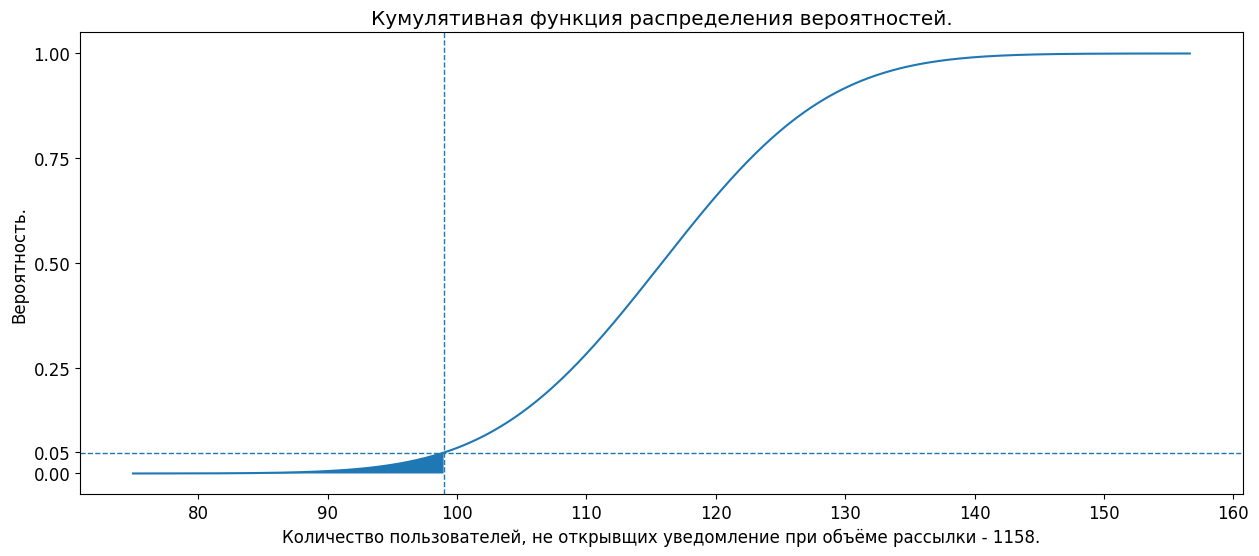

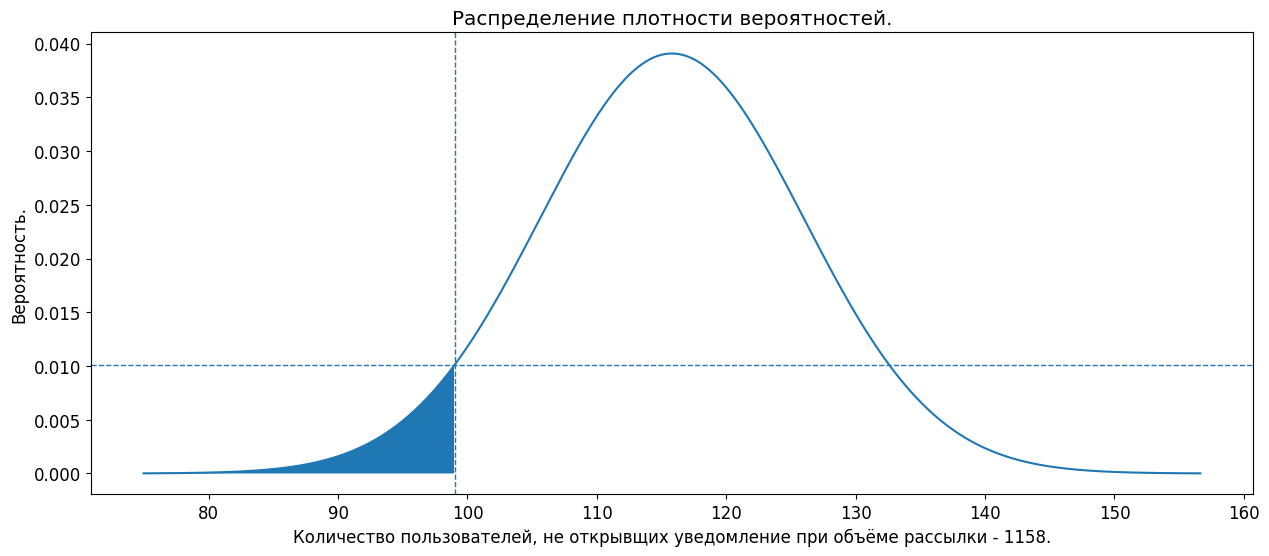

In [30]:
# Зададим недостающие параметры распределения
mu = n * p
sigma = sqrt(n * p * (1-p))

x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 500)
distr = st.norm(mu, sigma)
result = distr.cdf(k)


# Построим графики распределения плотности вероятности
# и кумулятивной функции нормального распределения
k_draw = np.arange(mu - 4 * sigma, k, 0.1)
plt.figure(figsize=(15,6))
plt.plot(x, distr.cdf(x))
plt.axvline(x=k, linewidth=1, linestyle='--')
plt.axhline(y=distr.cdf(k), linewidth=1, linestyle='--')
plt.fill_between(k_draw, distr.cdf(k_draw))
plt.title('Кумулятивная функция распределения вероятностей.')
plt.xlabel('Количество пользователей, не открывщих ' +
           f'уведомление при объёме рассылки - {n}.')
plt.ylabel('Вероятность.')
plt.yticks([0, 0.05, 0.25, 0.5, 0.75, 1])
plt.show();

plt.figure(figsize=(15,6))
plt.plot(x, distr.pdf(x))
plt.axvline(x=k, linewidth=1, linestyle='--')
plt.axhline(y=distr.pdf(k), linewidth=1, linestyle='--')
plt.fill_between(k_draw, distr.pdf(k_draw))
plt.title('Распределение плотности вероятностей.')
plt.xlabel('Количество пользователей, не открывщих ' +
           f'уведомление при объёме рассылки - {n}.')
plt.ylabel('Вероятность.')
plt.show();

#### Выводы:
Для вероятности не выполнить план в минимум 100 продлений подписки - 4.99%, минимальное количество разосланных промокодов - 1158.

### Оценка параметров рассылки.
Оценка вероятности того, что при рассылке 1 млн. push-уведомлений, их откроют не более 399,5 тыс. пользователей.<br>

Оценим вероятность с помощью метода `cdf()`. <br>
Построим графики распределения плотности вероятности и кумулятивной функции нормального распределения для проверки.

Вероятность того, что пуш-уведомление откроют менее 399,5 тыс. пользователей - 15%.


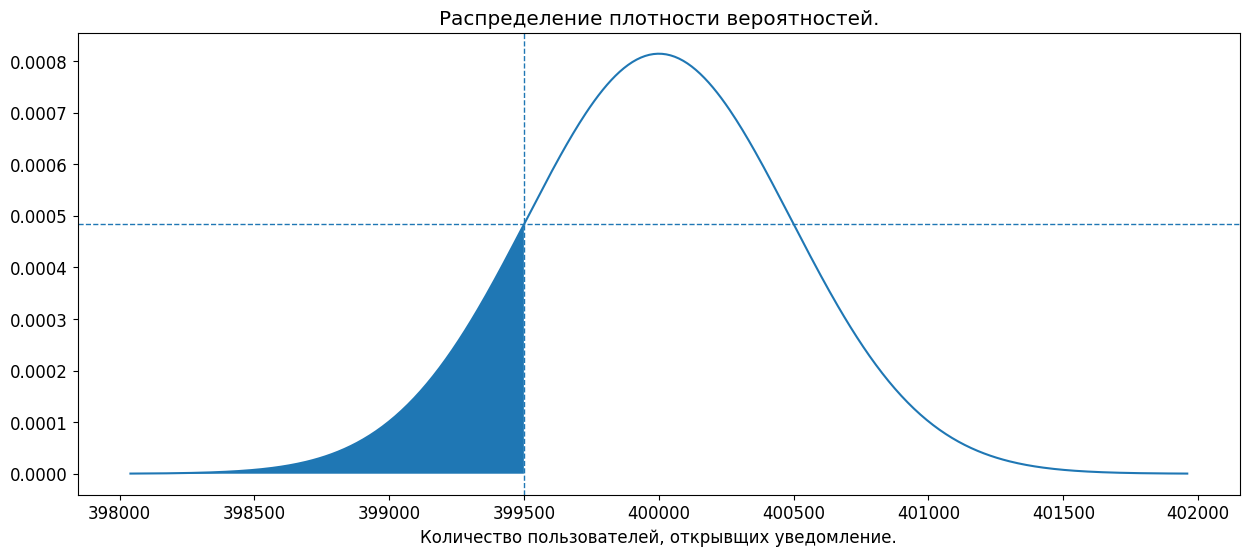

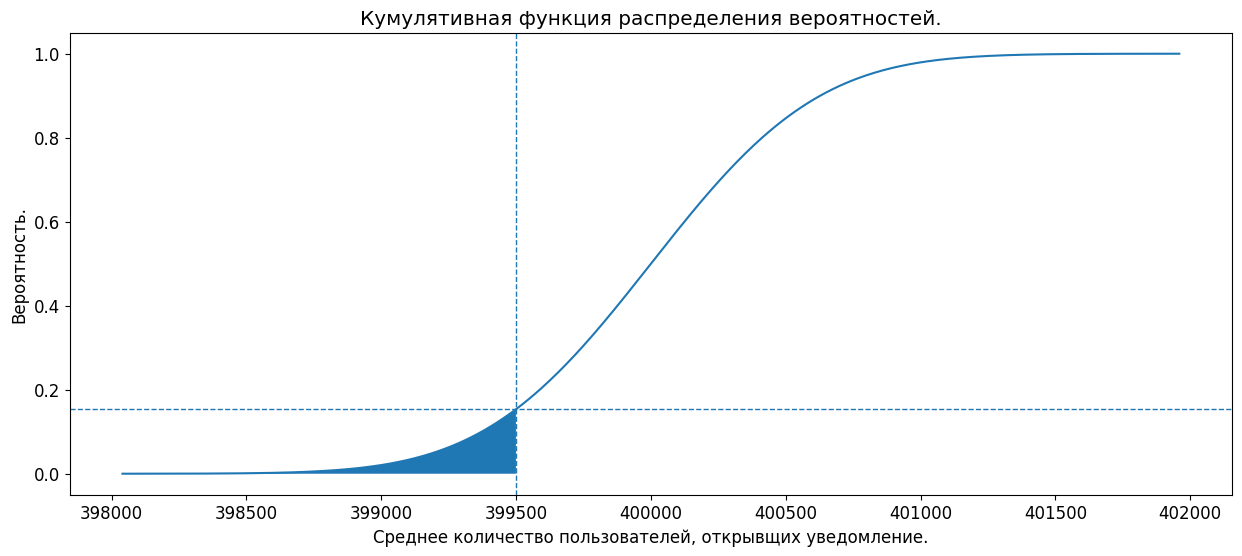

In [31]:
# Зададим параметры распределения
n = 1000000
k = 399500
p = 0.4
mu = n * p
sigma = sqrt(n * p * (1-p))


x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 500)
distr = st.norm(mu, sigma)
result = distr.cdf(k)

print('Вероятность того, что пуш-уведомление откроют менее',
      '399,5 тыс. пользователей - {:.0%}.'.format(result))

# Построим графики распределения плотности вероятности
# и кумулятивной функции нормального распределения
k_draw = np.arange(mu - 4 * sigma, k, 1)
plt.figure(figsize=(15,6))
plt.plot(x, distr.pdf(x))
plt.axvline(x=k, linewidth=1, linestyle='--')
plt.axhline(y=distr.pdf(k), linewidth=1, linestyle='--')
plt.fill_between(k_draw, distr.pdf(k_draw))
plt.title('Распределение плотности вероятностей.')
plt.xlabel('Количество пользователей, открывщих уведомление.')
plt.show();

plt.figure(figsize=(15,6))
plt.plot(x, distr.cdf(x))
plt.axvline(x=k, linewidth=1, linestyle='--')
plt.axhline(y=distr.cdf(k), linewidth=1, linestyle='--')
plt.fill_between(k_draw, distr.cdf(k_draw))
plt.title('Кумулятивная функция распределения вероятностей.')
plt.xlabel('Среднее количество пользователей, открывщих уведомление.')
plt.ylabel('Вероятность.')
plt.show();

#### Выводы:
Вероятность того, что пуш-уведомление откроют не более 399,5 тыс. пользователей - 15%.

## Общий вывод:<br>
<span id="fn15">

**Анализ параметров поездок клиентов сервиса аренды самокатов "GoFast".**<br>
- **Общий анализ.**
  - В Пятигорске и Москве больше всего и меньше всего клиентов соотетственно.
  - Пользователи с подпиской составляют 46% от общего количества.
  - Самое большое число подписчиков и пользователей в общем в Пятигорске, Екатеринбурге и Ростове-на-Дону.
  - Медианный возраст пользователей - 25 лет. Подписка более интересны пользователям от 18 до 33 лет.
  - Средняя поездка:
    - продолжительность - 17 минут;
    - расстояние - 3129м.
  - Рисунки распределений расстояний и длительности поездок дублируются с учетом того, что пользователи без подписки чаще берут самокаты в аренду. По графику расстояний можно отметить рост до 1500 м. - короткие поездки, и в районе 3000 м. - длительные.
- **Пользователи без подписки:**
  - чаще проезжат большие и малые расстояния;
  - чаще пользуются самокатами короткое время;
  - чаще берут самокаты в аренду;
  - среднее расстояние поездки - ~3000 м.;
  - среднее время поездки - ~17 минут;
- **Пользователи с подпиской:**
  - среднее расстояние поездки - ~3100 м.;
  - средняя длительность поездки - ~18 минут;
  - часто проезжают около 3000 м.;
  - особенно выделяются значения 1000 м., 3150 м. и 4000 м.

- **Проверка гипотез:**
  - Пользователи с подпиской тратят на поездки статистичеси значимо больше времени, чем пользователи без подписки.
  - Расстояние, которое проезжает статистически значимое количество пользователей с подпиской за одну поездку, превышает 3130 метров.
  - Месячная выручка от пользователей с подпиской по месяцам статистически значимо превышает выручку от пользователей без подписки.
  - Для проверки гипотезы о снижении количества обращений в техподдержку необходимо провести "тест гипотезы о равенстве средних для зависимых (парных) выборок": `st.ttest_rel(before, after)`
- **Оценка параметров:**
  - Для вероятности не выполнить план в минимум 100 продлений подписки - 4.99%, минимальное количество разосланных промокодов - 1158.
  - Вероятность того, что при рассылке 1 млн. пуш-уведомлений, его откроют не более 399,5 тыс. пользователей - 15%.